## Image Generation with Autoencoders, Variational Autoencoders, or GANs
### TMNIST-Alphabet (94 characters and over 281,000 images)

### Variational Autoencoders
Use variational autoencoders to generate fake images. Adjust the size of the latent space and change the network architecture to figure out the best combination of them to give the best trade-off between compression and quality.

In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils.vis_utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

intermediate_dim = 512
batch_size = 128
latent_dim = 2 # because of z_mean and z_log_variance
epochs = 50

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (original_dim, )

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1] # Returns the shape of tensor or variable as a tuple of int or None entries.
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
# VAE model = encoder + decoder
# build encoder model
def encoder_model(inputs):
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder, z_mean, z_log_var

In [5]:
inputs = Input(shape=input_shape, name='encoder_input')
encoder, z_mean, z_log_var = encoder_model(inputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense[0][0]']                  
                                                                                            

In [6]:
# build decoder model
def decoder_model():
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

In [7]:
decoder = decoder_model()
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [8]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               403972    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               403728    
                                                                 
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [9]:
reconstruction_loss = mse(inputs, outputs)
# reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [10]:
vae.fit(x_train, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 5s 9ms/step - loss: 52.0112 - val_loss: 44.0391
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 43.3135 - val_loss: 42.5602
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 42.3270 - val_loss: 41.8229
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 41.6864 - val_loss: 41.3237
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 41.1643 - val_loss: 40.7623
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 40.7718 - val_loss: 40.4170
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 40.4042 - val_loss: 40.1451
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 40.1167 - val_loss: 39.9368
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 39.8857 - val_loss: 39.7351
Epoch 10/10
469/469 [==============================] - 4s 8ms/step - loss: 39.6506

In [11]:
test_imgs = vae.predict(x_test)
print(test_imgs.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 784)


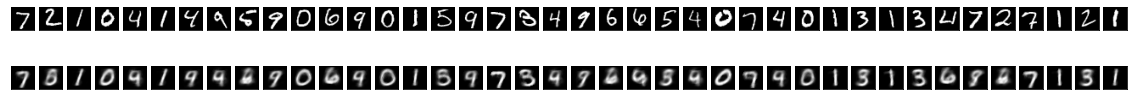

In [12]:
import matplotlib.pyplot as plt

n = 40  # how many digits we will display
plt.figure(figsize=(20, 2))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

For Variational Autoencoders, I use latent_dim = 2 and epcho = 50 to generate images. The result of this experiments show that VAE's overall performance was not good enough after the same 10 epochs. When latent_dim = 2 and epcho = 10, this architecture generate really good fake images.

Variational autoencoders (VAE) solve the problem of non-regularized potential Spaces in autoencoders and provide generative capability for the whole space. Encoder output potential vector in AE. The encoder for VAE does not output the vectors in the subspace, but the predefined distributed parameters in the subspace of each input. Then VAE imposes constraints on this potential distribution forcing it to become a normal distribution. This constraint ensures that the potential space is regularized.

After the same 10 epochs, VAE's overall performance was not good enough. But conceptually, its training limit should be more refined than AE.

VAE force the conditions of potential variables into the unit norm. The compressed form is the mean and variance of the potential variables. The underlying variables are smooth and continuous. Random values of potential variables produce meaningful output in the decoder. The input to the decoder is a random value sampled from a Gaussian with the mean and variance of the encoder's output.

### LICENSE

Copyright (C) <2022>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.